In [1]:
# %%
import sys
import os
from os import listdir
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import dask
from dask.diagnostics import ProgressBar
import regionmask
import geopandas as gpd

pbar = ProgressBar()
pbar.register()
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import seaborn as sns
import colour
from colour import Color
import matplotlib.colors
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import matplotlib.colors as mcolors
import matplotlib.colorbar as mcolorbar
import pandas as pd


In [2]:
# %%
###############################################################################################################################
##################################################### Setup ###################################################################
###############################################################################################################################

##################################### Paths #####################################

home = "/scistor/ivm/tbr910/"  # \\scistor.vu.nl\shares\BETA-IVM-BAZIS\tbr910\ # /scistor/ivm/tbr910/
path_base = home + "precip_analysis"
path_obs = home + "precip_analysis/obs"
path_forecasts = home + "precip_analysis/forecasts"
path_obs_for = home + "precip_analysis/obs_for"
path_q = home + "precip_analysis/quantiles"
path_cont = home + "precip_analysis/cont_metrics"
path_efi = home + "ECMWF/files_efi/"
path_verif = home + "precip_analysis/verif_files"
path_obs_for_new = home + "precip_analysis/obs_for_new_LT"
path_figs = home + "precip_analysis/figures"
path_return_periods = "/scistor/ivm/tbr910/precip_analysis/return_periods_europe"

##################################### Config  #####################################
# General config
indicator = "efi"  # efi, sot (or ES?)
shift = 1
resolution = "025"
day_month = "12_08"  # day and month seperated by an underscore
save_annotation = ""
# precipitation threshold
"""
Define precipitation threshold, options:

- Fixed percentiles: 0.95, 0.98, 0.99 (method var: quantile_extremes)
- Fixed rainfall amounts (mm): 40, 60, 90 (method var: threshold_method, not implemented yet?)
- Fixed return periods: 5RP, 10RP, 20RP (method var: return_periods)
"""
p_threshold = "5RP"


# C_L
find_C_L_max = False  # if True, we want to find the PEV for the C_L ratio for which Fval is max. If false, we want to find the PEV for a specific C_L ratio (specified in C_L_best_estimate)
C_L_best_estimate = 0.1  # 0.08 used in paper.
C_L_min = 0.02
C_L_max = 0.18

# file name strings
file_accessor = f'{indicator}_{day_month}_{str(p_threshold).replace(".","")}_S{shift}.nc'  # file accessor from the 'save_string' variable in PEV.py

##################################### Load data #####################################
os.chdir(path_verif)

# Europe files
# efi
if indicator == "efi":
    Fval_merged_efi = xr.open_dataset("Fval_merged_%s" % (file_accessor))

# sot
elif indicator == "sot":
    Fval_merged_sot = xr.open_dataset("Fval_merged_%s" % (file_accessor))

# specific area files
if indicator == "efi":
    Fval_region = xr.open_dataset("Fval_area_merged_%s" % (file_accessor))

elif indicator == "sot":
    Fval_region = xr.open_dataset("Fval_area_merged_%s" % (file_accessor))


print("total number of events on the ROI:", Fval_region.attrs)
print(
    "average number of events per pixel on the ROI:", Fval_region.n_events.mean().values
)


##################################### Retrieve lon lats for the ROI #####################################
"""
lon lat boxes 
[2.5, 14, 47.5, 55] --> large area Western Europe (used till now)
[3.95,7.8,49.3,51.3] --> Affected by 2021 floods
[-10, 20, 39, 55] --> much larger (rondom?) area
[1,7.8,47.5,51.3] --> area selected with high # events
"""

# retrieve lon lat box as saved in the Fval_region file as attributes
lon_lat_box = Fval_region.attrs["lon_slice"] + Fval_region.attrs["lat_slice"]
lon_lat_box = (
    lon_lat_box.replace("slice", "")
    .replace("None", "")
    .replace(",", "")
    .replace("(", "")
    .replace(")", "")
)  # remove the words slice and None
lon_lat_box = [float(i) for i in (lon_lat_box.split())]
lon_lat_box[2], lon_lat_box[3] = (
    lon_lat_box[3],
    lon_lat_box[2],
)  # switch last two numbers
print("lon_lat_box:", lon_lat_box)


total number of events on the ROI: {'n_events': 592.0, 'lon_slice': 'slice(3.5, 7.8, None)', 'lat_slice': 'slice(52, 48, None)'}
average number of events per pixel on the ROI: 2.2595419847328246
lon_lat_box: [3.5, 7.8, 48.0, 52.0]


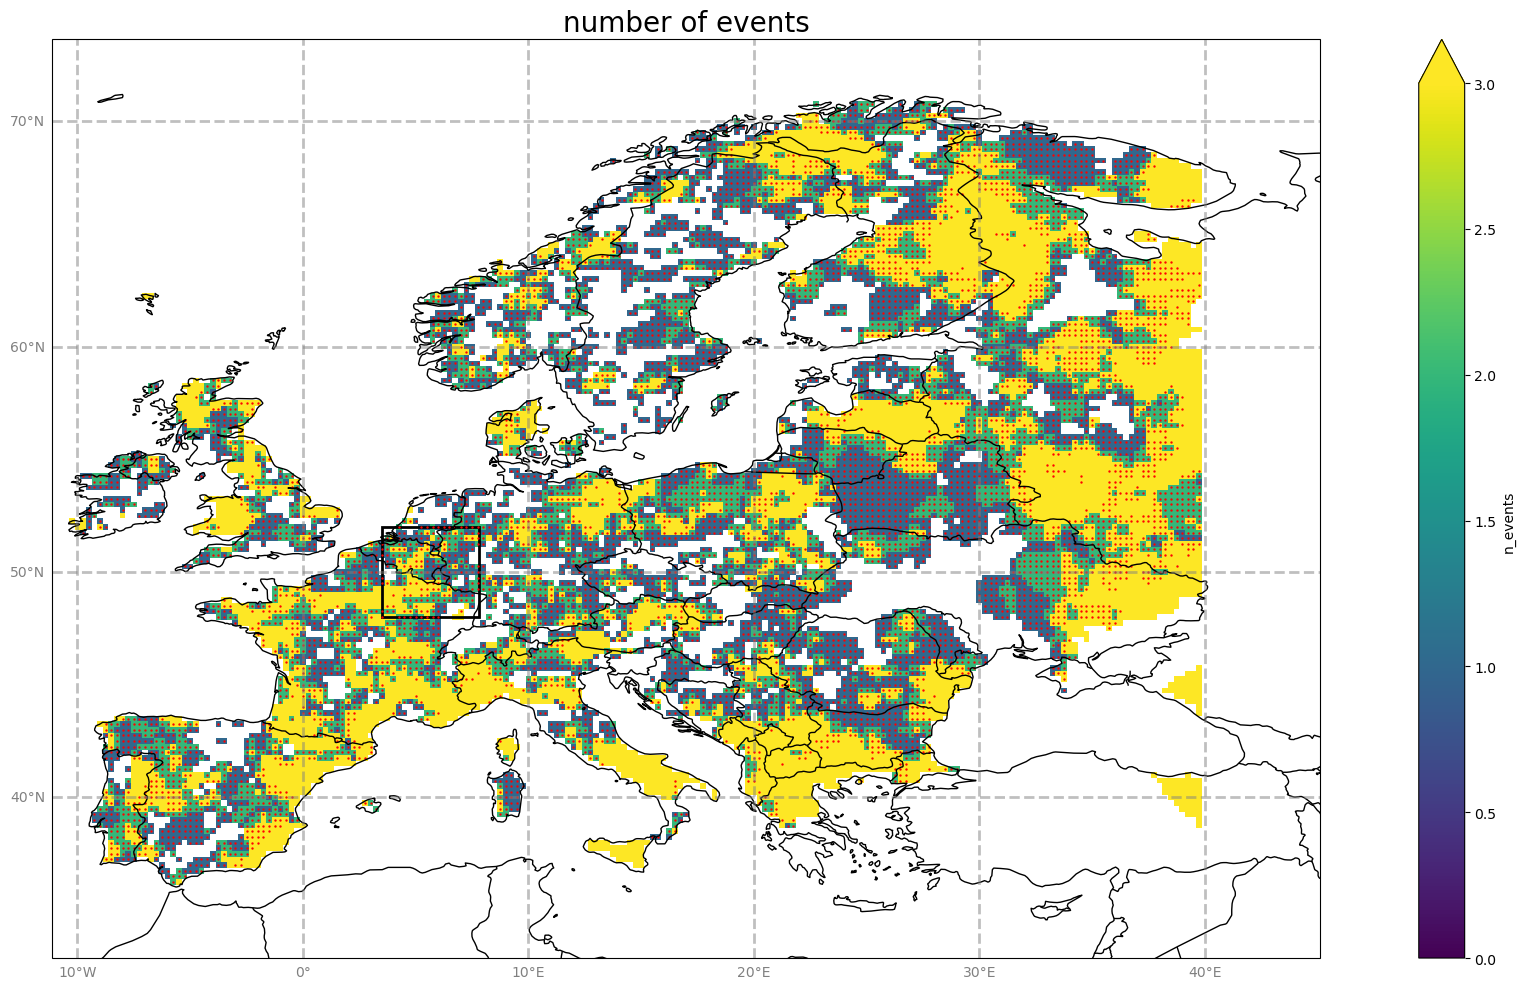

average number of events per pixel in the whole area : 2.8405616871340484


In [3]:
#%%
#############################################################################################################
##################################### Plot the number of extreme events #####################################
#############################################################################################################

# Load contingency metrics
cont_efi = xr.open_dataset("cont_metrics_merged_%s" % (file_accessor))
cont_sot = xr.open_dataset("cont_metrics_merged_%s" % (file_accessor))

# plot number of events
fig, ax = plt.subplots(figsize=(20, 10), subplot_kw={"projection": ccrs.PlateCarree()})
proj0 = ccrs.PlateCarree(central_longitude=0)

cont_sot.n_events.isel(lead=0).isel(ew_threshold=1).plot.pcolormesh(
    ax=ax, transform=ccrs.PlateCarree(central_longitude=0), vmin=0, vmax=3
)  # random lead and ew_threshold

ax.set_title(f"number of events", size=20)
gl = ax.gridlines(
    crs=proj0, draw_labels=True, linewidth=2, color="gray", alpha=0.5, linestyle="--"
)
gl.top_labels = False
gl.right_labels = False
gl.left_labels = True
gl.bottom_labels = True
gl.xlabel_style = {"color": "gray"}
gl.ylabel_style = {"color": "gray"}
ax.coastlines()
ax.add_feature(cfeature.BORDERS)

# Add the rectangle to each subplot
ax.add_patch(
    mpatches.Rectangle(
        xy=[lon_lat_box[0], lon_lat_box[2]],
        width=lon_lat_box[1] - lon_lat_box[0],
        height=lon_lat_box[3] - lon_lat_box[2],
        linewidth=2,
        edgecolor="black",
        facecolor="none",
        transform=ccrs.PlateCarree(central_longitude=0),
    )
)

################# add dots on map for n_events < 4 #################
# Create a mask for the condition
mask = cont_sot.n_events.isel(lead=0).isel(ew_threshold=1) < 4

# Get the longitude and latitude from the mask
lon, lat = np.meshgrid(cont_sot.longitude, cont_sot.latitude)

# Plot the red dots on the map where the condition is met
ax.scatter(lon[mask], lat[mask], color="red", transform=ccrs.PlateCarree(), s=0.5)

fig.tight_layout()

plt.show()
plt.close()

print(
    "average number of events per pixel in the whole area :",
    cont_efi.n_events.mean().values,
)


/tmp/ipykernel_2274723/1245948210.py:31: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap_F = plt.cm.get_cmap("RdYlGn", 14)
/tmp/ipykernel_2274723/1245948210.py:242: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


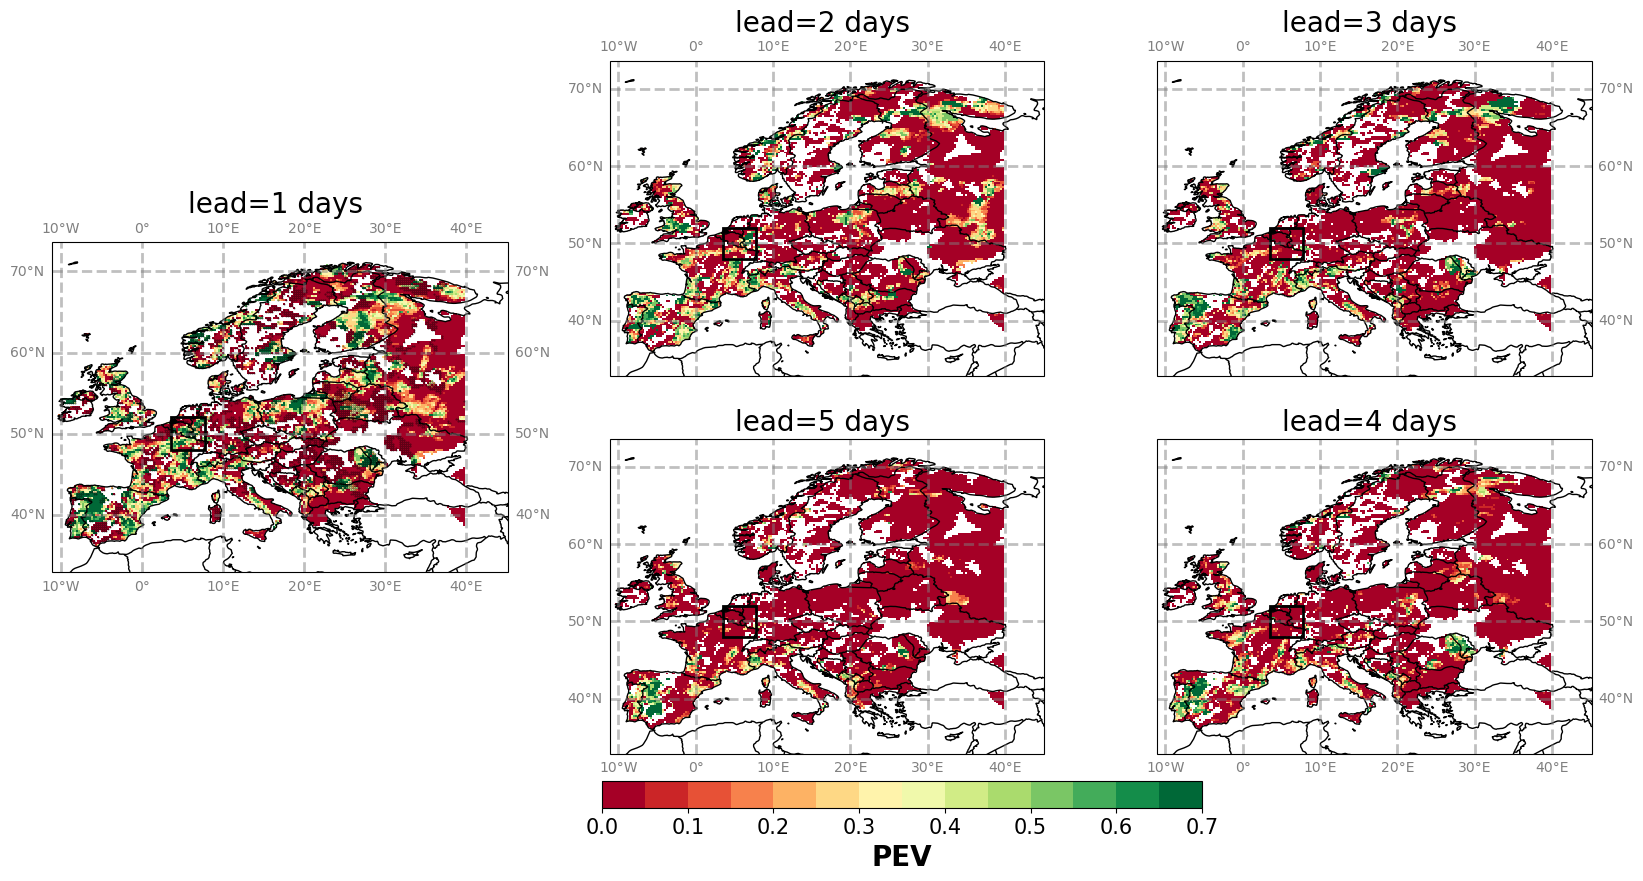

: 

In [4]:
# %%
###############################################################################################################################
########################################### European Fval plot for EFI and SOT ################################################
###############################################################################################################################

########################## Select the right C_L ratio ##########################
if find_C_L_max == True:  #  Find and select max Fval
    if indicator == "efi":
        Fval_plot = Fval_merged_efi.max(dim=("C_L", "ew_threshold")).Fval
    elif indicator == "sot":
        Fval_plot = Fval_merged_sot.max(dim=("C_L", "ew_threshold")).Fval

else:  # or select the Fval for a specific C_L ratio
    if indicator == "efi":
        Fval_plot = Fval_merged_efi.copy()

    elif indicator == "sot":
        Fval_plot = Fval_merged_sot.copy()

    Fval_plot = Fval_plot.sel(
        C_L=C_L_best_estimate
    ).Fval  # select the Fval for the C_L ratio we want to plot
    Fval_plot = Fval_plot.max(dim="ew_threshold")  # select max Fval for this C_L ratio


########################## Plot parameters ##########################
vmin = 0.0  # min value for the colorbar
vmax = 0.7  # max value for the colorbar

# red to green colormap
cmap_F = plt.cm.get_cmap("RdYlGn", 14)
# cmap_F=plt.cm.get_cmap('Greens', 10) # alternative colormap


########################## Start plotting ##########################

fig = plt.figure(figsize=(20, 9))  # (W,H)

# 5 subplots (in circle)
gs = fig.add_gridspec(2, 3, wspace=0.2, hspace=0.2)
ax1 = fig.add_subplot(
    gs[:, 0], projection=proj0
)  # ax1 over the first column stretching over 2 rows
ax2 = fig.add_subplot(gs[0, 1], projection=proj0)
ax3 = fig.add_subplot(gs[0, 2], projection=proj0)
ax4 = fig.add_subplot(gs[1, 2], projection=proj0)
ax5 = fig.add_subplot(gs[1, 1], projection=proj0)

# ax1
plot1 = Fval_plot.isel(lead=0).plot.pcolormesh(
    ax=ax1,
    transform=ccrs.PlateCarree(central_longitude=0),
    add_colorbar=False,
    vmin=vmin,
    vmax=vmax,
    cmap=cmap_F,
)  # plot the first lead
lead = Fval_plot.isel(lead=0).lead.values
ax1.set_title("lead=%s " % (lead), size=20)
gl = ax1.gridlines(
    crs=proj0, draw_labels=True, linewidth=2, color="gray", alpha=0.5, linestyle="--"
)
gl.top_labels = True
gl.right_labels = True
gl.left_labels = True
gl.bottom_labels = True
gl.xlabel_style = {"color": "gray"}
gl.ylabel_style = {"color": "gray"}
ax1.coastlines()
ax1.add_feature(cfeature.BORDERS)

# ax2
Fval_plot.isel(lead=1).plot.pcolormesh(
    ax=ax2,
    transform=ccrs.PlateCarree(central_longitude=0),
    add_colorbar=False,
    vmin=vmin,
    vmax=vmax,
    cmap=cmap_F,
)  # plot the second lead
lead = Fval_plot.isel(lead=1).lead.values
ax2.set_title("lead=%s " % (lead), size=20)
gl = ax2.gridlines(
    crs=proj0, draw_labels=True, linewidth=2, color="gray", alpha=0.5, linestyle="--"
)
gl.top_labels = True
gl.right_labels = False
gl.left_labels = True
gl.bottom_labels = False
gl.xlabel_style = {"color": "gray"}
gl.ylabel_style = {"color": "gray"}
ax2.coastlines()
ax2.add_feature(cfeature.BORDERS)

# ax3
Fval_plot.isel(lead=2).plot.pcolormesh(
    ax=ax3,
    transform=ccrs.PlateCarree(central_longitude=0),
    add_colorbar=False,
    vmin=vmin,
    vmax=vmax,
    cmap=cmap_F,
)  # plot the third lead
lead = Fval_plot.isel(lead=2).lead.values
ax3.set_title("lead=%s " % (lead), size=20)
gl = ax3.gridlines(
    crs=proj0, draw_labels=True, linewidth=2, color="gray", alpha=0.5, linestyle="--"
)
gl.top_labels = True
gl.right_labels = True
gl.left_labels = False
gl.bottom_labels = False
gl.xlabel_style = {"color": "gray"}
gl.ylabel_style = {"color": "gray"}
ax3.coastlines()
ax3.add_feature(cfeature.BORDERS)

# ax4
Fval_plot.isel(lead=3).plot.pcolormesh(
    ax=ax4,
    transform=ccrs.PlateCarree(central_longitude=0),
    add_colorbar=False,
    vmin=vmin,
    vmax=vmax,
    cmap=cmap_F,
)  # plot the fourth lead
lead = Fval_plot.isel(lead=3).lead.values
ax4.set_title("lead=%s " % (lead), size=20)
gl = ax4.gridlines(
    crs=proj0, draw_labels=True, linewidth=2, color="gray", alpha=0.5, linestyle="--"
)
gl.top_labels = False
gl.right_labels = True
gl.left_labels = False
gl.bottom_labels = True
gl.xlabel_style = {"color": "gray"}
gl.ylabel_style = {"color": "gray"}
ax4.coastlines()
ax4.add_feature(cfeature.BORDERS)

# ax5
Fval_plot.isel(lead=4).plot.pcolormesh(
    ax=ax5,
    transform=ccrs.PlateCarree(central_longitude=0),
    add_colorbar=False,
    vmin=vmin,
    vmax=vmax,
    cmap=cmap_F,
)  # plot the fifth lead
lead = Fval_plot.isel(lead=4).lead.values
ax5.set_title("lead=%s " % (lead), size=20)
gl = ax5.gridlines(
    crs=proj0, draw_labels=True, linewidth=2, color="gray", alpha=0.5, linestyle="--"
)
gl.top_labels = False
gl.right_labels = False
gl.left_labels = True
gl.bottom_labels = True
gl.xlabel_style = {"color": "gray"}
gl.ylabel_style = {"color": "gray"}
ax5.coastlines()
ax5.add_feature(cfeature.BORDERS)

# Add the ROI to each subplot
ax1.add_patch(
    mpatches.Rectangle(
        xy=[lon_lat_box[0], lon_lat_box[2]],
        width=lon_lat_box[1] - lon_lat_box[0],
        height=lon_lat_box[3] - lon_lat_box[2],
        linewidth=2,
        edgecolor="black",
        facecolor="none",
        transform=ccrs.PlateCarree(central_longitude=0),
    )
)
ax2.add_patch(
    mpatches.Rectangle(
        xy=[lon_lat_box[0], lon_lat_box[2]],
        width=lon_lat_box[1] - lon_lat_box[0],
        height=lon_lat_box[3] - lon_lat_box[2],
        linewidth=2,
        edgecolor="black",
        facecolor="none",
        transform=ccrs.PlateCarree(central_longitude=0),
    )
)
ax3.add_patch(
    mpatches.Rectangle(
        xy=[lon_lat_box[0], lon_lat_box[2]],
        width=lon_lat_box[1] - lon_lat_box[0],
        height=lon_lat_box[3] - lon_lat_box[2],
        linewidth=2,
        edgecolor="black",
        facecolor="none",
        transform=ccrs.PlateCarree(central_longitude=0),
    )
)
ax4.add_patch(
    mpatches.Rectangle(
        xy=[lon_lat_box[0], lon_lat_box[2]],
        width=lon_lat_box[1] - lon_lat_box[0],
        height=lon_lat_box[3] - lon_lat_box[2],
        linewidth=2,
        edgecolor="black",
        facecolor="none",
        transform=ccrs.PlateCarree(central_longitude=0),
    )
)
ax5.add_patch(
    mpatches.Rectangle(
        xy=[lon_lat_box[0], lon_lat_box[2]],
        width=lon_lat_box[1] - lon_lat_box[0],
        height=lon_lat_box[3] - lon_lat_box[2],
        linewidth=2,
        edgecolor="black",
        facecolor="none",
        transform=ccrs.PlateCarree(central_longitude=0),
    )
)


################# add dots on map for n_events 0 or 1#################
# Create a mask for the condition
mask = cont_sot.n_events.isel(lead=0).isel(ew_threshold=1) < 2

# Get the longitude and latitude from the mask
lon, lat = np.meshgrid(cont_sot.longitude, cont_sot.latitude)

# Plot the red dots on the map where the condition is met
ax1.scatter(
    lon[mask], lat[mask], color="black", transform=ccrs.PlateCarree(), s=0.2, alpha=0.5
)

################# Colorbar #################
cax1 = fig.add_axes([0.4, 0.05, 0.3, 0.03])  # [left, bottom, width, height]
cbar = plt.colorbar(plot1, pad=0.00, cax=cax1, orientation="horizontal", cmap=cmap_F)
cbar.set_label(label="PEV", size="20", weight="bold")
cbar.ax.tick_params(labelsize=15)
cbar.set_ticks(np.round(cbar.get_ticks(), 2))

########################################### save ################################################
fig.tight_layout()
plt.savefig(
    path_figs + "/PEV_eu_%s_%s.pdf" % (indicator, file_accessor), bbox_inches="tight"
)
plt.show()
plt.close()


In [5]:
# %%
###############################################################################################################################
########################################### PEV graph + warning thresholds  ####################################################
###############################################################################################################################

os.chdir(path_verif)

################# Load area data from the ROI #################
# efi
Fval_efi = xr.open_dataset(path_verif + "/Fval_area_merged_%s" % (file_accessor)).Fval
Fval_efi = Fval_efi.mean(
    dim=("latitude", "longitude")
)  # new in this revisions version, because before the PEV script already calculated the spatial average

# sot
Fval_sot = xr.open_dataset(path_verif + "/Fval_area_merged_%s" % (file_accessor)).Fval
Fval_sot = Fval_sot.mean(dim=("latitude", "longitude"))  # also new, see above

################################## STEP 1: Find ew thresholds per C/L value which generate maximum PEV ############################################
# these lines first identify the ew thresholds used to get the max PEV, then calculate the max PEV and attach the ew thresholds to this dataset

############ SOT #############
Fval_sot_max_index = Fval_sot.argmax(dim=("ew_threshold"))
ew_threshold_max = Fval_sot.ew_threshold[
    Fval_sot_max_index
]  # get the ew_thresholds for which the PEV is max
Fval_sot = Fval_sot.max(dim=("ew_threshold"))  # get the max PEV for each C/L
Fval_sot = Fval_sot.to_dataset(name="Fval")
Fval_sot["ew_threshold_max"] = (
    ew_threshold_max  # add the ew_thresholds for which the PEV is max to the dataset
)

############ EFI #############
Fval_efi_max_index = Fval_efi.argmax(dim=("ew_threshold"))
ew_threshold_max = Fval_efi.ew_threshold[
    Fval_efi_max_index
]  # get the ew_thresholds for which the PEV is max
Fval_efi = Fval_efi.max(dim=("ew_threshold"))  # get the max PEV for each C/L
Fval_efi = Fval_efi.to_dataset(name="Fval")
Fval_efi["ew_threshold_max"] = (
    ew_threshold_max  # add the ew_thresholds for which the PEV is max to the dataset
)

#################################### Step 2: retrieve the cont metrics for these ew thresholds (for C/L we want to calculate, either specific value or the one giving heighest PEV) ##################################
lead_cont = "1 days"  # lead time for which we want to calculate the cont metrics


######### EFI  #########
Fval_efi_lead = Fval_efi.sel(lead=lead_cont)

# 2.1: Select PEV and find/select C/L ratio
if find_C_L_max == True:
    PEV_cont_efi = Fval_efi_lead.where(
        Fval_efi_lead.Fval == Fval_efi_lead.Fval.max(), drop=True
    )  # select PEV max
    C_L_best_estimate_efi = (
        PEV_cont_efi.C_L.values
    )  # get the C_L ratio for which the PEV is max
else:
    C_L_best_estimate_efi = (
        C_L_best_estimate
    )  # use the C_L ratio specified in the config
    PEV_cont_efi = Fval_efi_lead.sel(
        C_L=C_L_best_estimate_efi
    )  # select the PEV for this C_L ratio

# 2.2 Retrieve early warning threshold that gives this max PEV
ew_max_efi = PEV_cont_efi.ew_threshold_max.values

# 2.3 use this ew threshold to select the cont metrics for this ew threshold
cont_max_efi = (
    cont_efi.sel(ew_threshold=ew_max_efi)
    .sel(lead=lead_cont)
    .mean(dim=("latitude", "longitude"))
)  # before it was mean, now sum to get the total number of events

n_fa_efi = float(cont_max_efi.false_alarms.values)  # false alarms
n_hits_efi = float(cont_max_efi.hits.values)  # hits
n_misses_efi = float(cont_max_efi.misses.values)  # misses
n_cn_efi = float(cont_max_efi.correct_negatives.values)  # correct negatives
far_efi = n_fa_efi / (n_fa_efi + n_cn_efi)  # false alarm rate
hr_efi = n_hits_efi / (n_hits_efi + n_misses_efi)  # hit rate

######### SOT  #########
Fval_sot_lead = Fval_sot.sel(lead=lead_cont)

# 2.1: Select PEV and find/select C/L ratio
if find_C_L_max == True:
    PEV_cont_sot = Fval_sot_lead.where(
        Fval_sot_lead.Fval == Fval_sot_lead.Fval.max(), drop=True
    )
    C_L_best_estimate_sot = PEV_cont_sot.C_L.values
else:
    C_L_best_estimate_sot = C_L_best_estimate
    PEV_cont_sot = Fval_sot_lead.sel(C_L=C_L_best_estimate_sot)

# 2.2 Retrieve early warning threshold that gives this max PEV
ew_max_sot = PEV_cont_sot.ew_threshold_max.values

# 2.3 use this ew threshold to select the cont metrics for this ew threshold
cont_max_sot = (
    cont_sot.sel(ew_threshold=ew_max_sot)
    .sel(lead=lead_cont)
    .mean(dim=("latitude", "longitude"))
)  # before it was mean, now sum to get the total number of events

n_fa_sot = float(cont_max_sot.false_alarms.values)  # false alarms
n_hits_sot = float(cont_max_sot.hits.values)  # hits
n_misses_sot = float(cont_max_sot.misses.values)  # misses
n_cn_sot = float(cont_max_sot.correct_negatives.values)  # correct negatives
far_sot = n_fa_sot / (n_fa_sot + n_cn_sot)  # false alarm rate
hr_sot = n_hits_sot / (n_hits_sot + n_misses_sot)  # hit rate


print(
    f"there are {n_fa_efi/n_hits_efi} and {n_fa_sot/n_hits_sot} false alarms per hit for EFI and SOT, respectively"
)

########################################  PEVmax graph ########################################################
# get data for the plot
Fval_sot_plot = Fval_sot.Fval
Fval_efi_plot = Fval_efi.Fval

#Reset to matplotlib's default style
matplotlib.rcParams.update(matplotlib.rcParamsDefault)

lead_times = Fval_efi.lead.values

# Create 2 subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 5), sharey=True)
# adjust widthspace
plt.subplots_adjust(wspace=0.2)
x_lim = 0.6
y_lim = 0.8
# Custom color palette
colors = sns.color_palette("mako", 5)


# Plot the data
for ax, Fval, title, n_hits, n_fa, n_misses, n_cn, hr, far, ew_threshold in zip(
    axs,
    [Fval_efi_plot, Fval_sot_plot],
    ["EFI", "SOT"],
    [n_hits_efi, n_hits_sot],
    [n_fa_efi, n_fa_sot],
    [n_misses_efi, n_misses_sot],
    [n_cn_efi, n_cn_sot],
    [hr_efi, hr_sot],
    [far_efi, far_sot],
    [float(ew_max_efi), float(ew_max_sot)],
):

    legend_handles = []
    for i in range(5):
        (line,) = ax.plot(
            Fval.C_L, Fval.isel(lead=i), color=colors[i], linewidth=3, alpha=0.7
        )
        ax.fill_between(
            Fval.C_L, 0, Fval.isel(lead=i), color=line.get_color(), alpha=0.1
        )

        # Highlight the peak of the curve
        max_pev = Fval.isel(lead=i).max()
        max_cl = Fval.C_L[Fval.isel(lead=i).argmax()]
        ax.plot(max_cl, max_pev, "o", color=line.get_color())

        # Add a horizontal line at the peak
        # ax.hlines(max_pev, ax.get_xlim()[0], ax.get_xlim()[1], colors=line.get_color(), linestyles='dashed', alpha=0.5)

        # Create a custom legend handle
        legend_handles.append(
            mlines.Line2D(
                [],
                [],
                color=line.get_color(),
                marker="o",
                markersize=5,
                label=f"Lead: {i+1} days",
            )
        )

    ax.set_xlabel("Action costs / prevented damage (C/L)", size=13, weight="bold")
    ax.set_ylabel("Forecast Value (PEV)", size=13, weight="bold")
    ax.set_xlim([0, x_lim])
    ax.set_ylim([0, y_lim])
    ax.set_xticks(np.arange(0, 0.7, 0.2))
    ax.set_yticks(np.arange(0.2, 0.8, 0.2))
    ax.tick_params(
        axis="both",
        which="both",
        direction="out",
        length=6,
        labelsize=13,
        colors="black",
    )

    # Add minor ticks
    # ax.minorticks_on()

    # Add grid for both major and minor ticks
    ax.grid(True, which="both", linestyle="--", linewidth=0.7, alpha=0.6, color="black")

    ############################################# Add table with cont metrics #############################################
    row_labels = ["Early Warning \n Early Action", "No Warning \n No Action"]
    col_labels = [" Extreme Rainfall \n Observed", " Extreme Rainfall \n Not Observed"]
    cell_text = [
        [f"Hits \n(n={(round(n_hits,2))})", f"False Alarms \n(n={round(n_fa,2)})"],
        [
            f"Misses \n(n={(round(n_misses,2))})",
            f"Correct Negatives \n(n={(round(n_cn,2))})",
        ],
    ]

    bbox = [-0.2, 1.1, 1, 0.4] if title == "EFI" else [0.4, 1.1, 1, 0.4]

    # Get the color of the line that corresponds to a lead of 1 day
    table_color = colors[1]

    # Change the color of the table lines
    table = ax.table(
        cellText=cell_text,
        rowLabels=row_labels,
        colLabels=col_labels,
        cellLoc="center",
        loc="upper center",
        bbox=bbox,
    )
    table.auto_set_font_size(False)
    table.set_fontsize(13)
    for (row, col), cell in table.get_celld().items():
        if (row == 0) or (col == -1):
            cell.set_fontsize(13)
            cell.set_text_props(weight="bold")
        cell.set_edgecolor(table_color)
        cell.set_linewidth(3)
    # Add the early warning threshold and lead time
    x_position = -0.15 if title == "EFI" else 0.44
    fig.text(
        x_position,
        1.25,
        f"{title} threshold = {ew_threshold}\nLead time = %s days" % (lead_cont[0]),
        fontsize=13,
        verticalalignment="top",
        fontstyle="italic",
    )

    # Add the hit rate and false alarm rate
    # ax.text(0.5, 0.9, f'Hit Rate: {hr:.2f}', size=12, ha='center', transform=ax.transAxes)
    # ax.text(0.5, 0.9, f'False Alarm Rate: {far:.2f}', size=12, ha='center', transform=ax.transAxes)

    ax.set_title(title, weight="bold")  # set title

    # Add vertical line at C-L ratio
    if title == "EFI":
        cl_ratio = C_L_best_estimate_efi
    else:
        cl_ratio = C_L_best_estimate_sot

    ax.axvline(x=cl_ratio, color="r", linestyle="--")

    # Shade the area between C_L_min and C_L_max
    ax.axvspan(C_L_min, C_L_max, color="grey", alpha=0.5)

# Add the legend with the maximum PEV values
fig.legend(
    handles=legend_handles,
    title_fontsize="15",
    fontsize=13,
    loc="upper right",
    bbox_to_anchor=(1.1, 0.6),
)

# Create a separate legend for the emergency flood measures
emergency_legend_handles = [
    mlines.Line2D([], [], color="red", linestyle="--", label="Best estimate"),
    mpatches.Patch(color="grey", alpha=0.5, label="Range"),
]
fig.legend(
    handles=emergency_legend_handles,
    title="C/L of Emergency \n flood measures",
    title_fontsize="15",
    fontsize=13,
    loc="lower right",
    bbox_to_anchor=(1.21, -0.1),
)

plt.savefig(path_figs + "/max_lead_time.pdf", bbox_inches="tight")

plt.show()
plt.close()

In [ ]:
# %%
###############################################################################################################################
########################################### Hits and False Alarms plot ########################################################
###############################################################################################################################

if indicator == "sot":
    Fval_plot = Fval_sot.copy()
    cont_plot = cont_sot.copy()
    cl_ratios = Fval_plot.C_L.values

if indicator == "efi":
    Fval_plot = Fval_efi.copy()
    cont_plot = cont_efi.copy()
    cl_ratios = Fval_plot.C_L.values


################################################### FIND CONT METRICS OVER CL RANGE ########################################################
cont_dataframe = pd.DataFrame(
    columns=[
        "lead",
        "C_L",
        "ew_threshold",
        "n_fa",
        "n_hits",
        "n_misses",
        "n_cn",
        "far",
        "hr",
    ]
)


for lead_cont in lead_times:
    Fval_efi_lead = Fval_plot.sel(lead=lead_cont)
    cont_efi_lead = cont_plot.sel(lead=lead_cont)
    for CL in cl_ratios:

        # retrieve ew threshold for the CL that gives max Fval
        PEV_cont_efi = Fval_efi_lead.sel(C_L=CL)
        ew_max_efi = PEV_cont_efi.ew_threshold_max.values
        cont_max_efi = cont_efi_lead.sel(ew_threshold=ew_max_efi).sum(
            dim=("latitude", "longitude")
        )  # before it was mean, now sum to get the total number of events

        n_fa_efi = float(cont_max_efi.false_alarms.values)  # false alarms
        n_hits_efi = float(cont_max_efi.hits.values)  # hits
        n_misses_efi = float(cont_max_efi.misses.values)  # misses
        n_cn_efi = float(cont_max_efi.correct_negatives.values)  # correct negatives
        far_efi = n_fa_efi / (n_fa_efi + n_cn_efi)  # false alarm rate
        hr_efi = n_hits_efi / (n_hits_efi + n_misses_efi)  # hit rate

        # add those to the dataframe (append is depreciated!!)
        cont_dataframe.loc[len(cont_dataframe)] = [
            lead_cont,
            CL,
            ew_max_efi,
            n_fa_efi,
            n_hits_efi,
            n_misses_efi,
            n_cn_efi,
            far_efi,
            hr_efi,
        ]


############################################  Start plotting #############################################
# Create a figure with 2 rows and 2 columns of subplots
fig, axs = plt.subplots(2, 1, figsize=(10, 10), sharex=True, sharey=True)
plt.subplots_adjust(wspace=0.2, hspace=0.3)

# Define the colors
colors = sns.color_palette("viridis", 5)

# Sample the C/L ratios
cl_ratios_sampled = np.linspace(
    cont_dataframe["C_L"].min(), cont_dataframe["C_L"].max(), 11
)

# Loop over the lead times
for i, lead in enumerate(cont_dataframe["lead"].unique()):
    # Filter the dataframe for the current lead time
    df_lead = cont_dataframe[cont_dataframe["lead"] == lead]

    # Plot the number of false alarms and number of hits for EFI
    axs[0].plot(
        df_lead["C_L"],
        df_lead["n_hits"],
        color=colors[i],
        linewidth=3,
        alpha=0.7,
        label=f"Lead: {lead} days",
    )
    axs[1].plot(
        df_lead["C_L"],
        df_lead["n_fa"],
        color=colors[i],
        linewidth=3,
        alpha=0.7,
        linestyle="--",
    )


# Set the labels, title, and other properties of the subplots
for ax, title in zip(
    axs.flat,
    ["%s Number of Hits" % (indicator), "%s Number of False Alarms" % (indicator)],
):
    ax.set_xlabel("Action costs / prevented damage (C/L)", size=13, weight="bold")
    ax.set_ylabel("Counts", size=13, weight="bold")
    ax.set_xticks(np.round(cl_ratios_sampled, 1))
    ax.tick_params(
        axis="both",
        which="both",
        direction="out",
        length=6,
        labelsize=13,
        colors="black",
    )
    ax.grid(True, which="both", linestyle="--", linewidth=0.7, alpha=0.6)
    ax.set_title(title, weight="bold", size=15)
    ax.legend()

# Limit the y-axis for the number of hits plots
axs[0].set_ylim(0, n_hits_efi)  # replace 100 with the desired upper limit
axs[1].set_ylim(0, n_hits_sot)  # replace 100 with the desired upper limit
print(n_hits_sot)
# Display the figure
plt.show()



In [ ]:
# %%
###############################################################################################################################
########################################### Rainfall thresholds plot  ########################################################
###############################################################################################################################

####################################### Percentiles #######################################

if "RP" not in p_threshold:  # plot percentiles
    ############################################ Percentile plots  #############################################
    # make a 4x4 percentile plot for the 4 seasons (DJF, MAM, JJA, SON)
    import matplotlib.colors as colors

    precip_q = xr.open_dataset(path_q + "/precip_q_%s_seasonal.nc" % (resolution))
    precip_q = precip_q.rr.sel(quantile=p_threshold)

    # precip_q.sel(quantile=p_threshold).rr.plot.imshow(vmin=0,vmax=20)

    # costum ECMWF colormap
    hex_ecmwf = [
        "#0c0173",
        "#226be5",
        "#216305",
        "#39af07",
        "#edf00f",
        "#f0ce0f",
        "#f08c0f",
        "#f0290f",
        "#e543e7",
        "#601a61",
    ]
    colors = [matplotlib.colors.to_rgb(i) for i in hex_ecmwf]
    n_bin = len(hex_ecmwf)
    cmap_P = LinearSegmentedColormap.from_list("cmap_ECMWF", colors, N=n_bin)

    # Create a 2x2 grid of subplots
    fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))
    plt.subplots_adjust(hspace=0.3)
    # Flatten the axes array so we can iterate over it
    axs = axs.flatten()

    # Plot each season on a different subplot
    for i, season in enumerate(precip_q.season.values):
        plot = precip_q.sel(season=season).plot(
            ax=axs[i], vmin=0, vmax=50, add_colorbar=False, cmap=cmap_P
        )
        axs[i].set_title(season, size=20)
    # Add a colorbar
    cax = fig.add_axes([0.95, 0.3, 0.01, 0.4])  # [left, bottom, width, height]
    cbar = plt.colorbar(plot, pad=0.00, cax=cax, orientation="vertical")
    cbar.set_label(label="Precipitation (mm/24h)", size="20", weight="bold")
    cbar.ax.tick_params(labelsize=15)

    # save to pdf
    plt.suptitle(
        f"Precipitation for different seasons (p_threshold: {p_threshold})", size=24
    )
    plt.savefig(path_figs + "/q_eu_map.png", bbox_inches="tight")
    plt.show()

if "RP" in p_threshold:  # plot percentiles
    import matplotlib.cm as cm

    precip_q = xr.open_dataset(
        path_return_periods
        + f"/precipitation-at-fixed-return-period_europe_e-obs_30-year_{p_threshold[:-2]}-yrs_1989-2018_v1.nc"
    )  # not used for threshold method, but still given to make the c_mask

    # Plotting precipitation quantiles
    fig, ax = plt.subplots(figsize=(10, 8))
    cmap = cm.get_cmap("Blues")
    contour = ax.contourf(
        precip_q.longitude,
        precip_q.latitude,
        precip_q[f"r{p_threshold[:-2]}yrrp"],
        cmap=cmap,
    )
    cbar = plt.colorbar(contour, ax=ax)
    cbar.ax.set_ylabel(f"Rainfall (mm/day)")
    ax.set_title("Precipitation Quantiles")
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    plt.title(f"Precipitation at fixed {p_threshold[:-2]} year return period")
    plt.show()



In [ ]:
# %%
###############################################################################################################################
########################################### PEVmax graph comparing EFI, SOT and EFI  ##########################################
###############################################################################################################################
# open Fval for ES, and calculate PEVmax
os.chdir(path_verif)
Fval_ES = xr.open_dataset(
    path_verif + "/Fval_area_merged_ES_%s.nc" % (file_accessor)
).Fval
Fval_ES = Fval_ES.mean(
    dim=("latitude", "longitude")
)  # new, because before the PEV script already calculated the spatial average
print(Fval_ES)

# find max ew threshold for each C/L for ES indicator (not done above)
Fval_ES_max_index = Fval_ES.argmax(dim=("ew_threshold"))
ew_threshold_max = Fval_ES.ew_threshold[Fval_ES_max_index]
Fval_ES = Fval_ES.max(dim=("ew_threshold"))
Fval_ES = Fval_ES.to_dataset(name="Fval")
Fval_ES["ew_threshold_max"] = ew_threshold_max


############ EFI #############


# plot Fval max for each lead time
fig = plt.figure(figsize=(15, 15))  # (W,H)

lead = 4
Fm_efi_lead = Fval_efi.isel(lead=lead).Fval
plt.plot(
    Fm_efi_lead.C_L.values, Fm_efi_lead.values, label="EFI", linewidth=3, color="red"
)
Fm_sot_lead = Fval_sot.isel(lead=lead).Fval
plt.plot(Fm_sot_lead.C_L, Fm_sot_lead.values, label="SOT", linewidth=3, color="blue")
Fm_ES_lead = Fval_ES.isel(lead=lead).Fval
plt.plot(Fm_ES_lead.C_L, Fm_ES_lead.values, label="ES", linewidth=3, color="green")

plt.xlabel("Cost-loss ratio", size=20, weight="bold")
plt.ylabel("Potential economic value (PEV)", size=20, weight="bold")
plt.xlim([0, x_lim])
plt.ylim([0, y_lim])
plt.xticks(np.arange(0, 0.7, 0.2), size=15)
plt.yticks(np.arange(0.2, 0.7, 0.2), size=15)
plt.title("lead=%s" % (lead), size=20)
plt.legend(fontsize=15, loc="lower right", bbox_to_anchor=(1.1, 0))

plt.show()
